In [4]:
import os
import sys
import pickle
import pandas as pd
import numpy as np
from concurrent.futures import ThreadPoolExecutor
import torch
import pickle
from sklearn.preprocessing import LabelEncoder
from torch.optim import optimizer
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from torch.nn import CrossEntropyLoss,BCEWithLogitsLoss
from tqdm import tqdm_notebook, trange
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM, BertForSequenceClassification
from pytorch_pretrained_bert.optimization import BertAdam, WarmupLinearSchedule
from sklearn.metrics import precision_recall_curve,classification_report
import matplotlib.pyplot as plt
%matplotlib inline

root_path = 'C:\\Users\\luoyan011\\Desktop\\PersonalLearning\\GitHub\\NLP_data\\simplifyweibo_4_moods'


Reference: https://zhuanlan.zhihu.com/p/72448986

In [24]:
data = pd.read_csv(os.path.join(root_path, "weibo_sample_4mood.csv"))
data.columns = ['label','text']
data = data[['text','label']]
data.sample(3,random_state=1)

,text,label
9953,。胔 igh 啊。。。然后我被阿紫追问【您是有安装着怪逼搜索雷达摸】。。。,2
3850,明天参加老爷子的遗体告别仪式。只希望所有人都坚强！,2
4962,过了过了~ (投稿),0


In [25]:
le = LabelEncoder()
le.fit(data.label.tolist())
data['label'] = le.transform(data.label.tolist())
data.sample(3,random_state=1)

,text,label
9953,。胔 igh 啊。。。然后我被阿紫追问【您是有安装着怪逼搜索雷达摸】。。。,2
3850,明天参加老爷子的遗体告别仪式。只希望所有人都坚强！,2
4962,过了过了~ (投稿),0


In [16]:
# 分词工具
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-chinese', do_lower_case=False)

# 封装类
class DataPrecessForSingleSentence(object):
    """
    对文本进行处理
    """

    def __init__(self, bert_tokenizer, max_workers=10):
        """
        bert_tokenizer :分词器
        dataset        :包含列名为'text'与'label'的pandas dataframe
        """
        self.bert_tokenizer = bert_tokenizer
        # 创建多线程池
        self.pool = ThreadPoolExecutor(max_workers=max_workers)
        # 获取文本与标签

    def get_input(self, dataset, max_seq_len=30):
        """
        通过多线程（因为notebook中多进程使用存在一些问题）的方式对输入文本进行分词、ID化、截断、填充等流程得到最终的可用于模型输入的序列。
        
        入参:
            dataset     : pandas的dataframe格式，包含两列，第一列为文本，第二列为标签。标签取值为{0,1}，其中0表示负样本，1代表正样本。
            max_seq_len : 目标序列长度，该值需要预先对文本长度进行分别得到，可以设置为小于等于512（BERT的最长文本序列长度为512）的整数。
        
        出参:
            seq         : 在入参seq的头尾分别拼接了'CLS'与'SEP'符号，如果长度仍小于max_seq_len，则使用0在尾部进行了填充。
            seq_mask    : 只包含0、1且长度等于seq的序列，用于表征seq中的符号是否是有意义的，如果seq序列对应位上为填充符号，
                          那么取值为1，否则为0。
            seq_segment : shape等于seq，因为是单句，所以取值都为0。
            labels      : 标签取值为{0,1}，其中0表示负样本，1代表正样本。
        
            
        """
        sentences = dataset.iloc[:, 0].tolist()
        labels = dataset.iloc[:, 1].tolist()
        # 切词
        tokens_seq = list(
            self.pool.map(self.bert_tokenizer.tokenize, sentences))
        # 获取定长序列及其mask
        result = list(
            self.pool.map(self.trunate_and_pad, tokens_seq,
                          [max_seq_len] * len(tokens_seq)))
        seqs = [i[0] for i in result]
        seq_masks = [i[1] for i in result]
        seq_segments = [i[2] for i in result]
        return seqs, seq_masks, seq_segments, labels

    def trunate_and_pad(self, seq, max_seq_len):
        """
        1. 因为本类处理的是单句序列，按照BERT中的序列处理方式，需要在输入序列头尾分别拼接特殊字符'CLS'与'SEP'，
           因此不包含两个特殊字符的序列长度应该小于等于max_seq_len-2，如果序列长度大于该值需要那么进行截断。
        2. 对输入的序列 最终形成['CLS',seq,'SEP']的序列，该序列的长度如果小于max_seq_len，那么使用0进行填充。
        
        入参: 
            seq         : 输入序列，在本处其为单个句子。
            max_seq_len : 拼接'CLS'与'SEP'这两个特殊字符后的序列长度
        
        出参:
            seq         : 在入参seq的头尾分别拼接了'CLS'与'SEP'符号，如果长度仍小于max_seq_len，则使用0在尾部进行了填充。
            seq_mask    : 只包含0、1且长度等于seq的序列，用于表征seq中的符号是否是有意义的，如果seq序列对应位上为填充符号，
                          那么取值为1，否则为0。
            seq_segment : shape等于seq，因为是单句，所以取值都为0。
           
        """
        # 对超长序列进行截断
        if len(seq) > (max_seq_len - 2):
            seq = seq[0:(max_seq_len - 2)]
        # 分别在首尾拼接特殊符号
        seq = ['[CLS]'] + seq + ['[SEP]']
        # ID化
        seq = self.bert_tokenizer.convert_tokens_to_ids(seq)
        # 根据max_seq_len与seq的长度产生填充序列
        padding = [0] * (max_seq_len - len(seq))
        # 创建seq_mask
        seq_mask = [1] * len(seq) + padding
        # 创建seq_segment
        seq_segment = [0] * len(seq) + padding
        # 对seq拼接填充序列
        seq += padding
        assert len(seq) == max_seq_len
        assert len(seq_mask) == max_seq_len
        assert len(seq_segment) == max_seq_len
        return seq, seq_mask, seq_segment

The pre-trained model you are loading is an uncased model but you have set `do_lower_case` to False. We are setting `do_lower_case=True` for you but you may want to check this behavior.
100%|███████████████████████████████| 109540/109540 [00:00<00:00, 685778.35B/s]


In [27]:
# 类初始化
processor = DataPrecessForSingleSentence(bert_tokenizer= bert_tokenizer)
# 产生输入ju 数据
seqs, seq_masks, seq_segments, labels = processor.get_input(
    dataset=data
    , max_seq_len=30)

In [29]:
# 加载预训练的bert模型
model = BertForSequenceClassification.from_pretrained(
    'bert-base-chinese', num_labels=4)


 17%|████▎                    | 66753536/382072689 [00:11<00:48, 6564832.30B/s]


 35%|████████▍               | 134173696/382072689 [00:22<00:42, 5783601.36B/s]


 51%|████████████▎           | 195972096/382072689 [00:33<00:30, 6049341.79B/s]


 70%|████████████████▋       | 266441728/382072689 [00:44<00:20, 5577771.36B/s]


 88%|█████████████████████   | 335172608/382072689 [00:55<00:07, 6554035.86B/s]


100%|████████████████████████| 382072689/382072689 [01:02<00:00, 6098409.91B/s]


In [32]:
# 转换为torch tensor
t_seqs = torch.tensor(seqs, dtype=torch.long)
t_seq_masks = torch.tensor(seq_masks, dtype = torch.long)
t_seq_segments = torch.tensor(seq_segments, dtype = torch.long)
t_labels = torch.tensor(labels, dtype = torch.long)

train_data = TensorDataset(t_seqs, t_seq_masks, t_seq_segments, t_labels)
train_sampler = RandomSampler(train_data)
train_dataloder = DataLoader(dataset= train_data, sampler= train_sampler,batch_size = 256)

In [34]:
# 将模型转换为trin mode
model.train()


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

In [36]:
from torch import nn
class BertPooler(nn.Module):
    def __init__(self, config):
        super(BertPooler, self).__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.activation = nn.Tanh()

    def forward(self, hidden_states):
        # We "pool" the model by simply taking the hidden state corresponding
        # to the first token.
        first_token_tensor = hidden_states[:, 0]
        pooled_output = self.dense(first_token_tensor)
        pooled_output = self.activation(pooled_output)
        return pooled_output

In [38]:
# 待优化的参数
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']

optimizer_grouped_parameters = [
    {
        'params':
        [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
        'weight_decay':
        0.01
    },
    {
        'params':
        [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
        'weight_decay':
        0.0
    }
]

optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=2e-05,
                     warmup= 0.1 ,
                     t_total= 2000)

device = 'cpu'

In [42]:
# 存储每一个batch的loss
loss_collect = []
for i in trange(2, desc='Epoch'):
    for step, batch_data in enumerate(
            tqdm_notebook(train_dataloder, desc='Iteration')):
        batch_data = tuple(t.to(device) for t in batch_data)
        batch_seqs, batch_seq_masks, batch_seq_segments, batch_labels = batch_data
        # 对标签进行onehot编码
        one_hot = torch.zeros(batch_labels.size(0), 4).long()
        one_hot_batch_labels = one_hot.scatter_(
            dim=1,
            index=torch.unsqueeze(batch_labels, dim=1),
            src=torch.ones(batch_labels.size(0), 4).long())

        logits = model(
            batch_seqs, batch_seq_masks, batch_seq_segments, labels=None)
        logits = logits.softmax(dim=1)
        loss_function = CrossEntropyLoss()
        loss = loss_function(logits, batch_labels)
        loss.backward()
        loss_collect.append(loss.item())
        print("\r%f" % loss, end='')
        optimizer.step()
        optimizer.zero_grad()


Epoch:   0%|                                             | 0/2 [00:00<?, ?it/s]<ipython-input-42-c1c9fc3715d6>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tqdm_notebook(train_dataloder, desc='Iteration')):


Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

1.181278


Epoch:  50%|█████████████████▌                 | 1/2 [28:38<28:38, 1718.66s/it]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

1.305909


Epoch: 100%|███████████████████████████████████| 2/2 [57:55<00:00, 1737.82s/it]


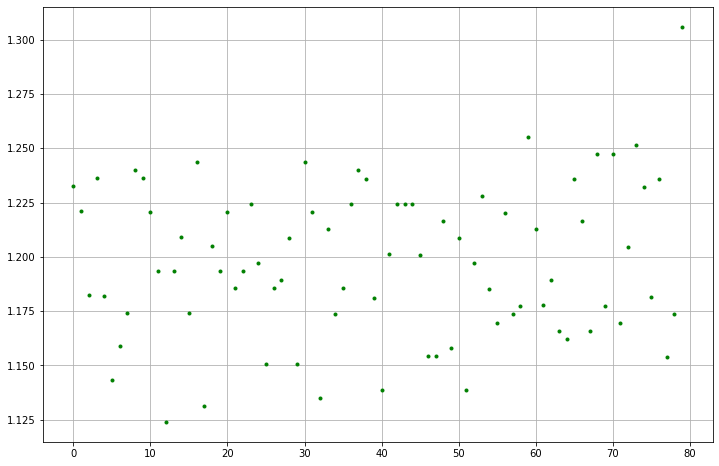

In [69]:
torch.save(model,open(os.path.join(root_path,"fine_tuned_chinese_bert.bin"),"wb"))
plt.figure(figsize=(12,8))
plt.plot(range(len(loss_collect)), loss_collect,'g.')
plt.grid(True)
plt.show()

In [71]:
test_data

,text,label
7878,2,回复总有一些故事会让我们感动总有一些坚持让我们汗颜总有一些守望让我们看到希望~ ！看了，很感...
3224,0,【7种食物改善心情】①巧克力减少应激激素水平缓解紧张情绪②菠菜富含叶酸消除倦怠③花生酱富含蛋...
1919,0,好贱的狗郁闷中的时候成功笑了，谢谢~ ！装B 的最高境界。
4432,0,很无耐也很无辜，但是现实就是这么残酷，卡卡需要学习和成长。
4835,2,我最近变的好宅好宅.要发霉了谁带我出去溜达溜达~
4895,0,好饿啊咸味香肠面包的链接也重新放一次好了beitaichufang .com recipe ...
7269,0,拼国粹，他们哪里是对手哦中国队力压阿根廷
1451,0,我的一个朋友的QQ 签名：再丑也要谈恋爱~ ~ 谈到世界充满爱~ ~ ~ ~
1742,3,珍惜身边人加油啊！我们全部都支持你啊。
4628,1,伤得不轻！糖糖疼得站都站不起来！


In [72]:
# rawdata = pd.read_csv(os.path.join(root_path,'simplifyweibo_4_moods.csv'))
rawdata = data.sample(50,random_state=2)
# rawdata.columns = ['label','text']
test_data = rawdata[['text','label']]
print(test_data)
# 标签ID化
test_data['label'] = le.transform(test_data.label.tolist())
# 转换为tensor
test_seqs, test_seq_masks, test_seq_segments, test_labels = processor.get_input(
    dataset=test_data, max_seq_len=30)
test_seqs = torch.tensor(test_seqs, dtype=torch.long)
test_seq_masks = torch.tensor(test_seq_masks, dtype = torch.long)
test_seq_segments = torch.tensor(test_seq_segments, dtype = torch.long)
test_labels = torch.tensor(test_labels, dtype = torch.long)
test_data = TensorDataset(test_seqs, test_seq_masks, test_seq_segments, test_labels)
test_dataloder = DataLoader(dataset= test_data, batch_size = 1)
# 用于存储预测标签与真实标签
true_labels = []
pred_labels = []
model.eval()
# 预测
with torch.no_grad():
    for batch_data in tqdm_notebook(test_dataloder, desc = 'TEST'):
        batch_data = tuple(t.to(device) for t in batch_data)
        batch_seqs, batch_seq_masks, batch_seq_segments, batch_labels = batch_data        
        logits = model(
            batch_seqs, batch_seq_masks, batch_seq_segments, labels=None)
        logits = logits.softmax(dim=1).argmax(dim = 1)
        pred_labels.append(logits.detach().numpy())
        true_labels.append(batch_labels.detach().numpy())
# 查看各个类别的准召
print(classification_report(np.concatenate(true_labels), np.concatenate(pred_labels)))       

                                                   text  label
7878  回复总有一些故事会让我们感动总有一些坚持让我们汗颜总有一些守望让我们看到希望~ ！看了，很感...      2
3224  【7种食物改善心情】①巧克力减少应激激素水平缓解紧张情绪②菠菜富含叶酸消除倦怠③花生酱富含蛋...      0
1919                      好贱的狗郁闷中的时候成功笑了，谢谢~ ！装B 的最高境界。      0
4432                      很无耐也很无辜，但是现实就是这么残酷，卡卡需要学习和成长。      0
4835                           我最近变的好宅好宅.要发霉了谁带我出去溜达溜达~      2
4895  好饿啊咸味香肠面包的链接也重新放一次好了beitaichufang .com recipe ...      0
7269                               拼国粹，他们哪里是对手哦中国队力压阿根廷      0
1451             我的一个朋友的QQ 签名：再丑也要谈恋爱~ ~ 谈到世界充满爱~ ~ ~ ~      0
1742                                珍惜身边人加油啊！我们全部都支持你啊。      3
4628                                   伤得不轻！糖糖疼得站都站不起来！      1
7053                    我来晚了咩？？被子大哥，早上好！久闻大名哇！晒被子都没位置了…      1
3634  北京的朋友注意一下。看到请帮忙转！！帮忙转万能的微博你显灵吧家里人肯定急死了~ 帮忙转【寻人...      3
3215        江苏综艺台8月2日起周一至周四每晚10：15播出“家族诞生”我哭……上海看不到这地方台      3
3707                                          826快樂 ～～～      0
7066                               这要是06年决赛就好了。太他妈搞了！！！

<ipython-input-72-456d06848cb3>:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_data in tqdm_notebook(test_dataloder, desc = 'TEST'):


TEST:   0%|          | 0/50 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.52      1.00      0.68        26
           1       0.00      0.00      0.00         7
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00        11

    accuracy                           0.52        50
   macro avg       0.13      0.25      0.17        50
weighted avg       0.27      0.52      0.36        50



C:\Users\luoyan011\.conda\envs\nlp\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\luoyan011\.conda\envs\nlp\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\luoyan011\.conda\envs\nlp\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [73]:
print(pred_labels)

[array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64),

In [67]:
print(true_labels)

[array([3], dtype=int64), array([0], dtype=int64), array([3], dtype=int64), array([0], dtype=int64), array([1], dtype=int64), array([0], dtype=int64), array([3], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([3], dtype=int64), array([2], dtype=int64), array([0], dtype=int64), array([2], dtype=int64), array([3], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([2], dtype=int64), array([3], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([2], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([2], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([2], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([1], dtype=int64), array([0], dtype=int64),